### Basic pipeline

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)


### Pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

### Confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


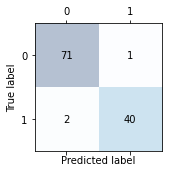

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

### Performance metrics

In [12]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from rich.console import Console
from rich.table import Table
def print_results(val_pred, labels, threshold=0.5):
    """ Take the labels and predictions from the model, calculate various metrics and out results in a table
    Parameters
    ----------
    val_pred : outputted confidence scores from the model
    labels : true labels for the data
    threshold : threshold to use when calculating metrics
    Returns
    -------
    dictionary of model metrics
    """
    # determine the binary predictions
    #val_pred = [conf > threshold for conf in val_pred]
    # calculate performance metrics
    precision, recall, _ = precision_recall_curve(labels, val_pred)
    results = {
        "confusion_matrix": confusion_matrix(labels, val_pred),
        "precision": precision_score(labels, val_pred),
        "recall": recall_score(labels, val_pred),
        "f1": f1_score(labels, val_pred),
        "roc_auc_score": roc_auc_score(labels, val_pred),
        "precision-recall AUC": auc(recall, precision),
    }
    # extract the individual components of the confusion matrix
    conf_comps = results["confusion_matrix"]
    conf_comps = conf_comps.flatten()
    conf_names = ["TN", "FP", "FN", "TP"]
    conf_comp_dict = {}
    for i, name in enumerate(conf_names):
        conf_comp_dict[name] = conf_comps[i]
    # add components to the front of a new dictionary
    new_results = {**conf_comp_dict, **results}
    del new_results["confusion_matrix"]
    # create table
    table = Table(title="\nValidation Metrics")
    metrics = []
    for name, metric in new_results.items():
        # put scores in percentage form
        if name not in conf_names and metric < 1:
            metric = "{val}%".format(val=round(metric * 100, 1))
        # everything else is standard form
        else:
            metric = str(round(metric, 1))
        table.add_column(name)
        metrics.append(metric)
    # add the properly formatted metrics
    table.add_row(*metrics)
    console = Console()
    console.print(table, "\n")
    return new_results

In [13]:
print_results(y_pred,y_test)

                                                                                         
                                   Validation Metrics                                    
┏━━━━┳━━━━┳━━━━┳━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ TN ┃ FP ┃ FN ┃ TP ┃ precision ┃ recall ┃ f1    ┃ roc_auc_score ┃ precision-recall AUC ┃
┡━━━━╇━━━━╇━━━━╇━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 71 │ 1  │ 2  │ 40 │ 97.6%     │ 95.2%  │ 96.4% │ 96.9%         │ 97.3%                │
└────┴────┴────┴────┴───────────┴────────┴───────┴───────────────┴──────────────────────┘

{'TN': 71,
 'FP': 1,
 'FN': 2,
 'TP': 40,
 'precision': 0.975609756097561,
 'recall': 0.9523809523809523,
 'f1': 0.963855421686747,
 'roc_auc_score': 0.9692460317460317,
 'precision-recall AUC': 0.9727672840638181}

### Plotting a receiver operating characteristic

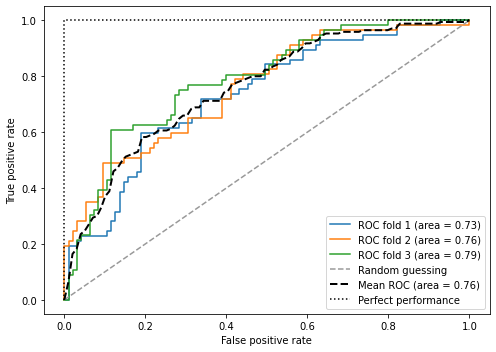

In [25]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from numpy import interp



pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()